# Quantization to 8bit int for SNN

In [60]:
import torch
import pickle
import os
import snntorch as snn
import torch.nn as nn
import numpy as np
from collections import OrderedDict

import os

In [61]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as torchvision_transforms
import tonic
import tonic.transforms as transforms

# Define sensor size for NMNIST dataset
sensor_size = tonic.datasets.NMNIST.sensor_size

# Define transformations
# Note: The use of torch.from_numpy is removed as Tonic's transforms handle conversion.
transform = tonic.transforms.Compose([
    transforms.Denoise(filter_time=10000),
    transforms.ToFrame(sensor_size=sensor_size, time_window=10000),
    # torchvision.transforms.RandomRotation is not directly applicable to event data.
    # If rotation is needed, it should be done on the frames after conversion by ToFrame.
])

# Load NMNIST datasets without caching
trainset = tonic.datasets.NMNIST(save_to='tmp/data', transform=transform, train=True)
testset = tonic.datasets.NMNIST(save_to='tmp/data', transform=transform, train=False)

# Split trainset into training and validation datasets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

# Fetch a single batch from the train_loader to inspect the shape
data, targets = next(iter(train_loader))
print(f"Data shape: {data.shape}")  # Example output: torch.Size([batch_size, timesteps, channels, height, width])
print(f"Targets shape: {targets.shape}")  # Example output: torch.Size([batch_size])

Data shape: torch.Size([31, 128, 2, 34, 34])
Targets shape: torch.Size([128])


In [62]:
config = {
    # SNN
    "threshold1": 2.5,
    "threshold2": 8.0,
    "threshold3": 4.0,
    "beta": 0.5,
    "num_steps": 10,
    
    # SNN Dense Shape
    "dense1_input": 2312,
    "num_classes": 10,

    # Hyper Params
    "lr": 0.007,

    # Early Stopping
    "min_delta": 1e-6,
    "patience_es": 20,

    # Training
    "epochs": 1
}

### Last model trained with FC layers and LIF


In [54]:
class SNN(nn.Module):
  def __init__(self, config):
    super(SNN, self).__init__()

    # Initialize configuration parameters
      # LIF
    self.thresh1 = config["threshold1"]
    self.thresh2 = config["threshold2"]
    self.thresh3 = config["threshold3"]
    self.beta = config["beta"]
    self.num_steps = config["num_steps"]

      # Dense Shape
    self.dense1_input = config["dense1_input"]
    self.num_classes = config["num_classes"]

      # Network Layers
    self.fc1 = nn.Linear(self.dense1_input, self.dense1_input//4)
    self.lif1 = snn.Leaky(beta=self.beta, threshold=self.thresh1)
    
    
    self.fc2 = nn.Linear(self.dense1_input//4, self.dense1_input//8)
    self.lif2 = snn.Leaky(beta=self.beta, threshold=self.thresh2)
    
    self.fc3 = nn.Linear(self.dense1_input//8, self.num_classes)
    self.lif3 = snn.Leaky(beta=self.beta, threshold=self.thresh3)
    
    self.flatten = nn.Flatten()
    
    
    # Forward Pass
  def forward(self, inpt):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()
    mem3 = self.lif3.init_leaky()

    spike3_rec = []
    mem3_rec = []

    for step in range(inpt.shape[0]):
      #print(inpt[step].shape)
      
      current_input = inpt[step]
      current_input = self.flatten(current_input)
      
      current1 = self.fc1(current_input)
      spike1, mem1 = self.lif1(current1, mem1)

      current2 = self.fc2(spike1)
      spike2, mem2 = self.lif2(current2, mem2)

      current3 = self.fc3(spike2)
      spike3, mem3 = self.lif3(current3, mem3)

      spike3_rec.append(spike3)
      mem3_rec.append(mem3)

    return torch.stack(spike3_rec, dim=0), torch.stack(mem3_rec, dim=0)

In [48]:
import torch
import matplotlib.pyplot as plt

def visualize_weights(model):
    """
    Visualize the weight distribution of a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose weights are to be visualized.
    """
    # Iterate through each model parameter (weights in this case)
    for name, parameter in model.named_parameters():
        if 'weight' in name:  # focusing only on weights
            plt.figure(figsize=(10, 4))
            weights = parameter.detach().cpu().numpy().flatten()
            print(weights)
            plt.hist(weights, bins=100, alpha=0.75)
            plt.title(f'Weight Histogram - {name}')
            plt.xlabel('Weight Values')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

In [47]:
import matplotlib.pyplot as plt

def plot_weight_histograms(model):
    for name, param in model.named_parameters():
        if 'weight' in name:  # Again, focusing on weight tensors
            plt.figure()
            plt.hist(param.data.numpy().flatten(), bins=50)
            plt.title(f"Histogram of weights in {name}")
            plt.xlabel('Weight values')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

fc1.weight - Min: -0.020797250792384148, Max: 0.02079715207219124, Mean: 1.2343546131887706e-06, Std: 0.012008167803287506
fc2.weight - Min: -0.04159392789006233, Max: 0.041594430804252625, Mean: 4.966136839357205e-05, Std: 0.02402278408408165
fc3.weight - Min: -0.05879218503832817, Max: 0.058749064803123474, Mean: -0.0002712805289775133, Std: 0.03379875421524048
[ 0.01055798  0.00874061 -0.00173798 ...  0.00137925 -0.01485436
  0.01256578]


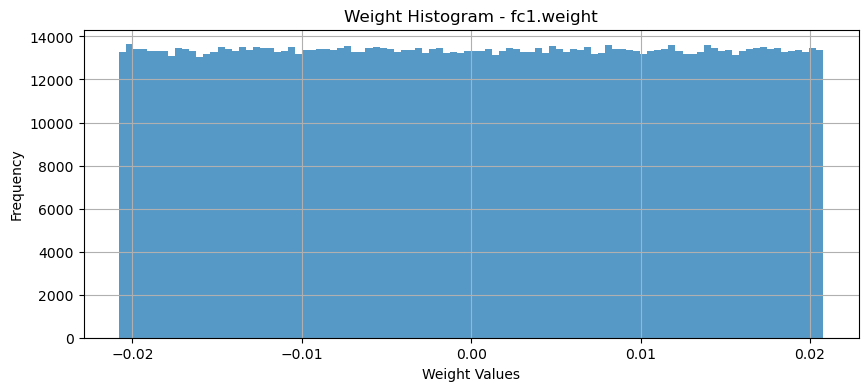

[-0.00163514  0.00394608  0.01478702 ... -0.01770801  0.00685211
  0.03103922]


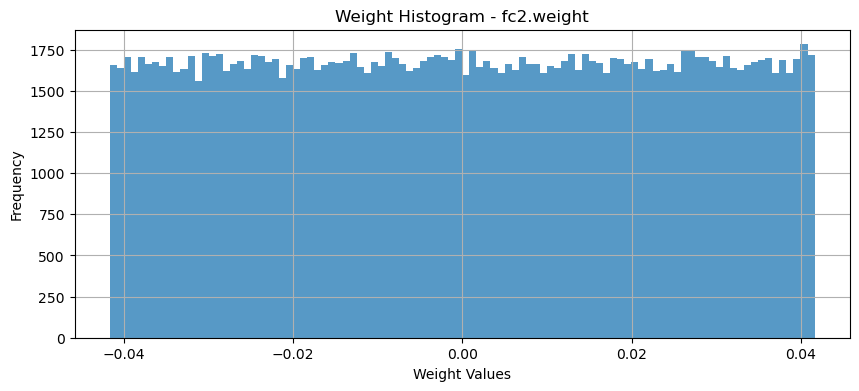

[-5.7578284e-02  4.2223159e-02  3.2013193e-02 ...  1.9329015e-02
 -3.9915364e-02 -7.0796297e-05]


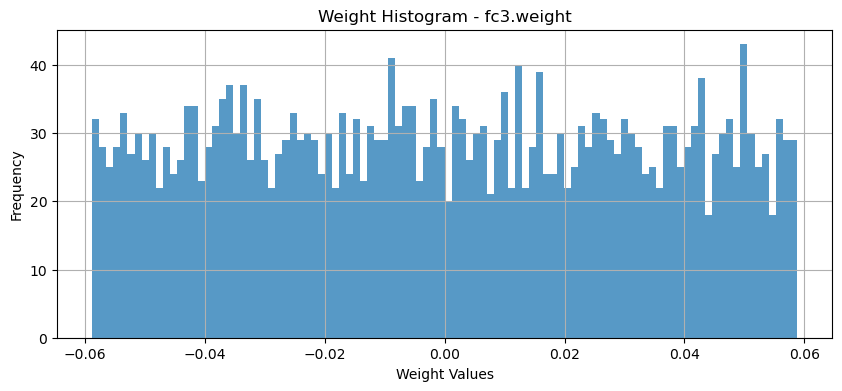

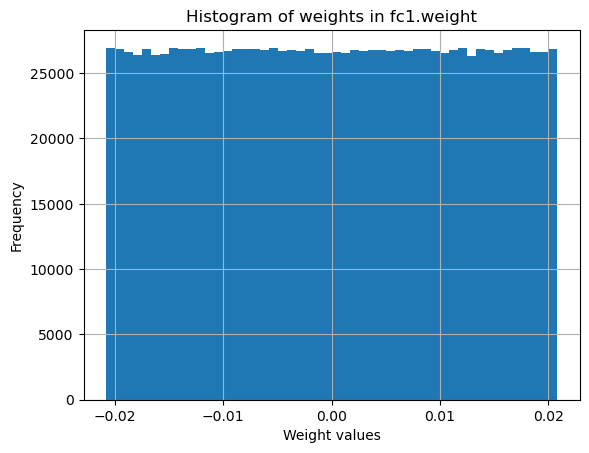

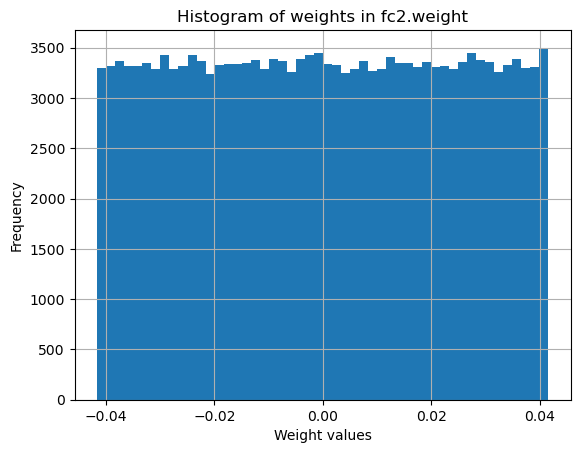

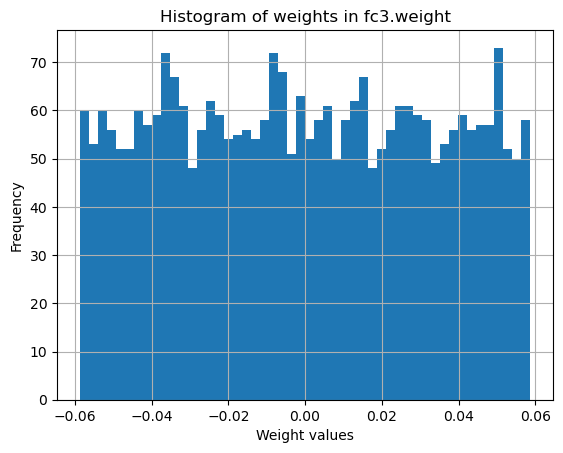

In [56]:
model_path = 'best_SNN_model.pth'
model = SNN(config)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

def inspect_initial_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} - Min: {param.min()}, Max: {param.max()}, Mean: {param.mean()}, Std: {param.std()}")

# Check weights before quantization
model = SNN(config)
inspect_initial_weights(model)
visualize_weights(model)
plot_weight_histograms(model)

### RoundAndClamp quantization

[-0.014  0.01   0.001 ...  0.006 -0.004  0.002]


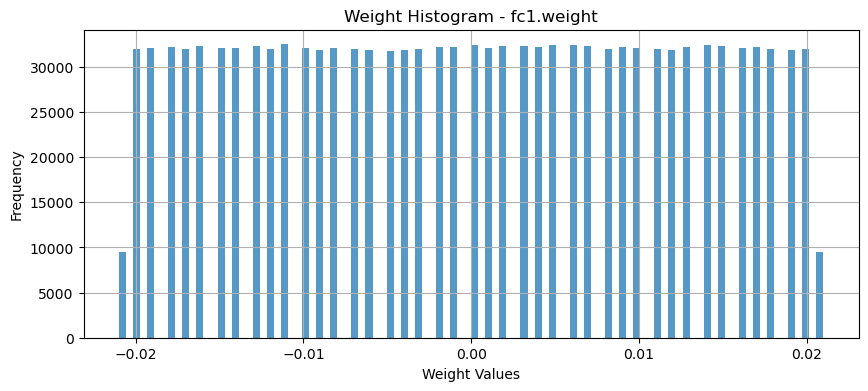

[ 0.013  0.     0.005 ...  0.04  -0.01  -0.014]


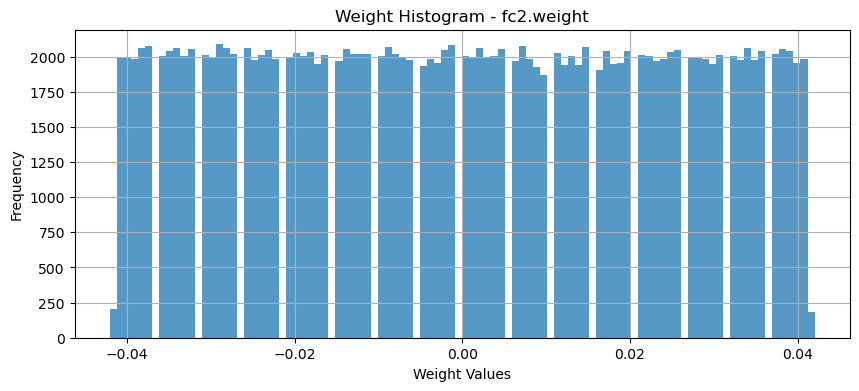

[ 0.058 -0.046 -0.002 ...  0.04  -0.01   0.046]


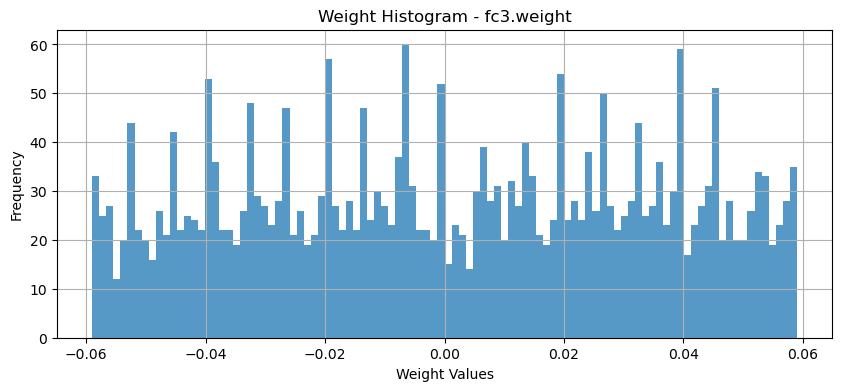

fc1.weight - Min: -0.020999999716877937, Max: 0.020999999716877937, Mean: 4.8198940021393355e-06, Std: 0.012007520534098148
fc2.weight - Min: -0.041999999433755875, Max: 0.041999999433755875, Mean: -0.00011386956612113863, Std: 0.024052446708083153
fc3.weight - Min: -0.05900000035762787, Max: 0.05900000035762787, Mean: 0.0008653979166410863, Std: 0.03348372504115105


In [45]:
class DynamicRoundAndClamp(Quantizer):
    def __init__(self, scale_factor: float = None, padding_factor: float = 1.1):
        super().__init__()
        self.scale_factor = scale_factor
        self.padding_factor = padding_factor

    def __call__(self, model: nn.Module):
        for name, param in model.named_parameters():
            if 'weight' in name and param.requires_grad:
                param_min = param.data.min()
                param_max = param.data.max()
                range_width = (param_max - param_min) * self.padding_factor
                param_center = (param_max + param_min) / 2

                lower_limit = param_center - range_width / 2
                upper_limit = param_center + range_width / 2

                if self.scale_factor:
                    lower_limit *= self.scale_factor
                    upper_limit *= self.scale_factor

                with torch.no_grad():
                    scaled_param = param * self.scale_factor if self.scale_factor else param
                    param_rounded = torch.round(scaled_param)
                    param_clamped = torch.clamp(param_rounded, lower_limit, upper_limit)
                    param.copy_(param_clamped / self.scale_factor if self.scale_factor else param_clamped)



# Example usage
model = SNN(config)
quantizer = DynamicRoundAndClamp(scale_factor=1000)  # Optional scaling factor
quantizer(model)
visualize_weights(model)
inspect_initial_weights(model)

[-0.01  0.02  0.01 ... -0.   -0.   -0.02]


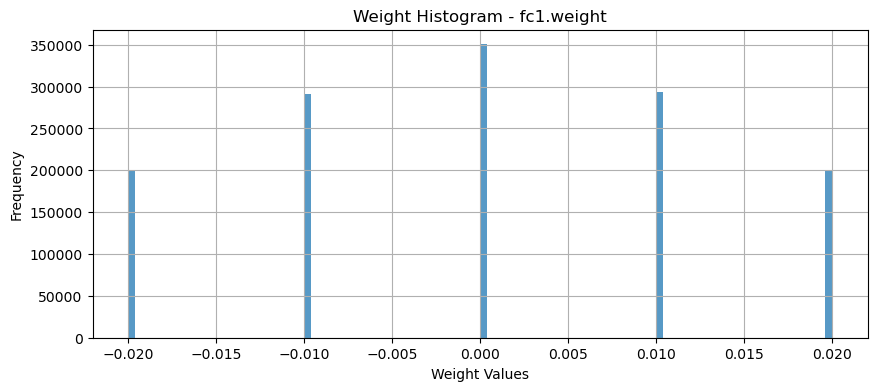

[-0.01 -0.02 -0.02 ... -0.02 -0.02  0.02]


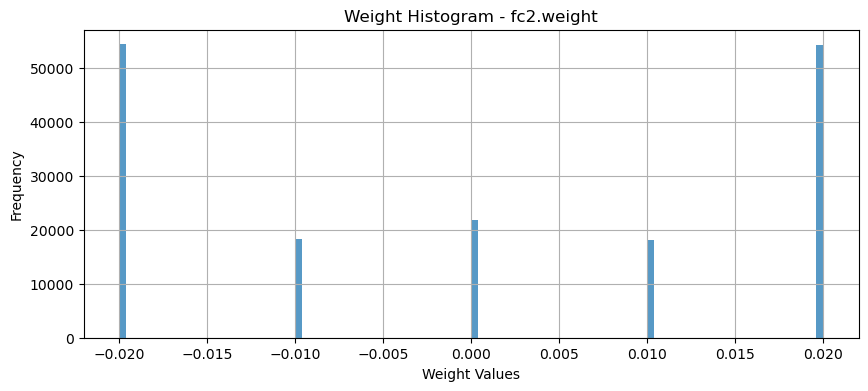

[-0.02  0.02  0.02 ...  0.02  0.01  0.02]


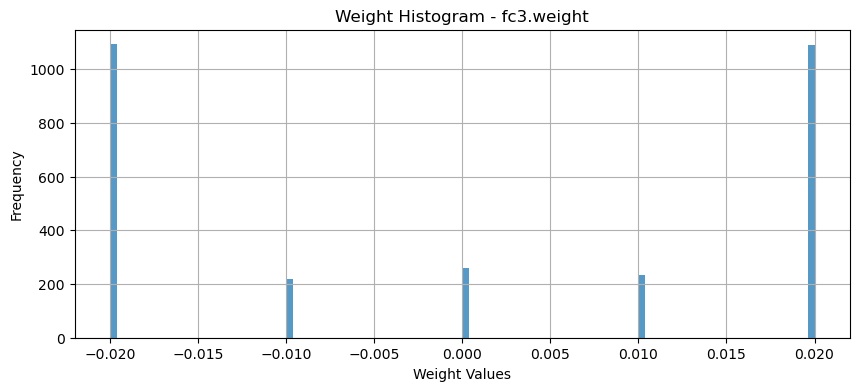

In [42]:
import torch
import matplotlib.pyplot as plt

class RoundAndClamp(Quantizer):
    def __init__(self, lower_limit: int, upper_limit: int, scale_factor: float, add_remainder: bool = False):
        super().__init__()
        self.lower_limit = lower_limit
        self.upper_limit = upper_limit
        self.scale_factor = scale_factor
        self.add_remainder = add_remainder
        self.synaptic_weight_remainder = None

    def __call__(self, model: nn.Module):
        if self.synaptic_weight_remainder is None:
            self.synaptic_weight_remainder = [None] * len(list(model.parameters()))

        for idx, param in enumerate(model.parameters()):
            if param.requires_grad:
                with torch.no_grad():
                    # Scale up the weights before rounding and clamping
                    scaled_param = param * self.scale_factor
                    if self.add_remainder and self.synaptic_weight_remainder[idx] is not None:
                        scaled_param += self.synaptic_weight_remainder[idx]
                    param_rounded = torch.round(scaled_param)
                    param_clamped = torch.clamp(param_rounded, self.lower_limit, self.upper_limit)
                    if self.add_remainder:
                        self.synaptic_weight_remainder[idx] = scaled_param - param_clamped
                    # Scale down the weights to their original range after quantization
                    param.copy_(param_clamped / self.scale_factor)

def visualize_weights(model):
    """
    Visualize the weight distribution of a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose weights are to be visualized.
    """
    # Iterate through each model parameter (weights in this case)
    for name, parameter in model.named_parameters():
        if 'weight' in name:  # focusing only on weights
            plt.figure(figsize=(10, 4))
            weights = parameter.detach().cpu().numpy().flatten()
            print(weights)
            plt.hist(weights, bins=100, alpha=0.75)
            plt.title(f'Weight Histogram - {name}')
            plt.xlabel('Weight Values')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

# Scaling the weights by a factor of 1000 might be a starting point
quantizer = RoundAndClamp(-25, 25, 500, add_remainder=True)
quantized_model = quantizer(model)  # Apply quantization
visualize_weights(model)

In [17]:
import torch

class RoundAndClamp:
    def __init__(self, lower_limit, upper_limit):
        self.lower_limit = lower_limit
        self.upper_limit = upper_limit

    def __call__(self, model):
        with torch.no_grad():
            for param in model.parameters():
                if param.requires_grad:
                    # Round the weights and clamp them within the specified range
                    param.data = torch.round(param.data)
                    param.data.clamp_(self.lower_limit, self.upper_limit)


In [18]:
def apply_quantization_and_save(model, quantizer, path="model_quantized.pth"):
    # Apply quantization
    quantizer(model)
    # Save the quantized model
    torch.save(model.state_dict(), path)


In [23]:
apply_quantization_and_save(model, RoundAndClamp(-128, 128), path="model_quantized.pth")

In [24]:
import torch
import matplotlib.pyplot as plt

def visualize_weights(path, model_class, config):
    # Load the model
    model = model_class(config)
    model.load_state_dict(torch.load(path))
    model.eval()

    # Iterate through each model parameter (weights in this case)
    for name, parameter in model.named_parameters():
        if 'weight' in name:  # focusing only on weights
            plt.figure(figsize=(10, 4))
            plt.hist(parameter.detach().numpy().flatten(), bins=100)
            plt.title(f'Weight Histogram - {name}')
            plt.xlabel('Weight Values')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

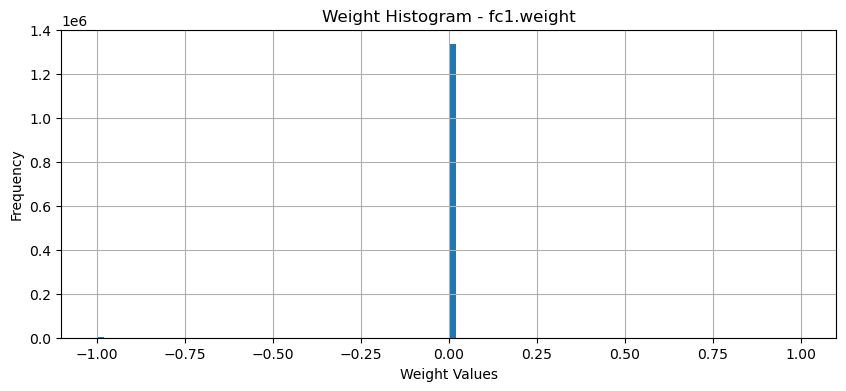

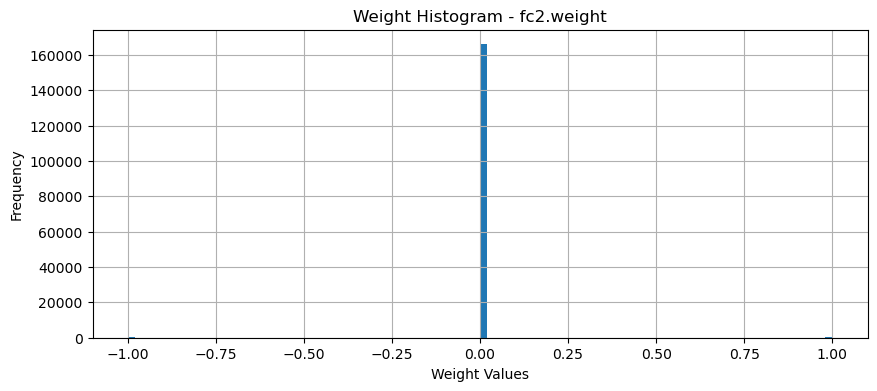

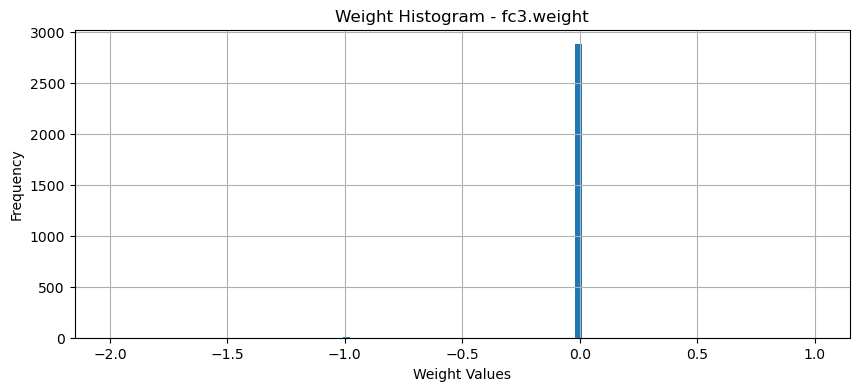

In [25]:
# Assuming `SNN` is your model class and `config` is the configuration dictionary
visualize_weights('model_quantized.pth', SNN, config)


[-0.  0. -0. ...  0. -0.  0.]


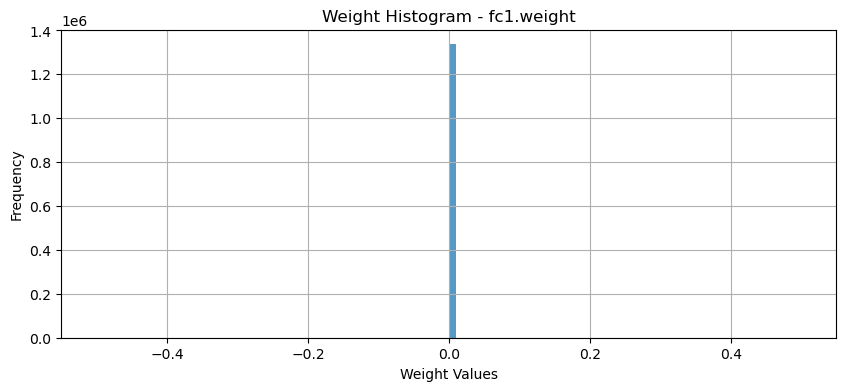

[-0. -0. -0. ...  0.  0. -0.]


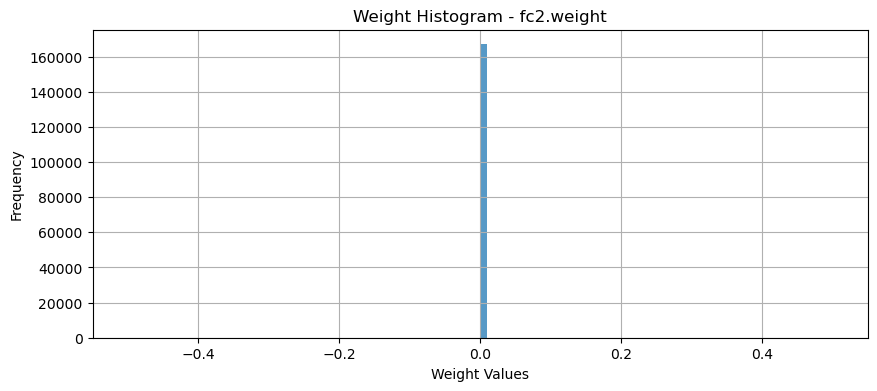

[-0.  0. -0. ...  0.  0. -0.]


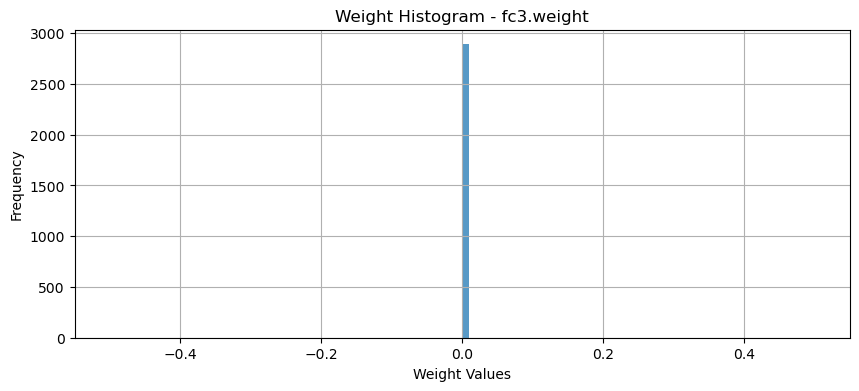

In [30]:
import torch
from torch import nn
from abc import ABC, abstractmethod

class Quantizer(ABC):
    """
    Base class for quantizers.
    """

    def __repr__(self):
        return f"{self.__class__.__name__}({self._class_repr()})"

    def _class_repr(self):
        """
        Set additional representation for implemented classes
        """
        return ''

    @abstractmethod
    def __call__(self, model: nn.Module):
        """
        Any quantizer should implement the __call__ method

        Args:
            model (nn.Module): Target model for quantization of the weights.
        """
        raise NotImplementedError(f"[{type(self).__name__}] is missing the required '__call__' function")

class RoundAndClamp(Quantizer):
    """
    Performs quantization on the synaptic weights of a model.
    Rounds and clamps the weights to the range [lower_limit, upper_limit],
    remainder is stored as an attribute such that it can be added the next time you call
    the quantizer if add_remainder is True.
    """
    def __init__(self, lower_limit: int, upper_limit: int, add_remainder: bool = False):
        super().__init__()
        self.lower_limit = lower_limit
        self.upper_limit = upper_limit
        self.add_remainder = add_remainder
        self.synaptic_weight_remainder = None

    def _class_repr(self):
        return f"lower_limit={self.lower_limit}, upper_limit={self.upper_limit}, add_remainder={self.add_remainder}"

    def __call__(self, model: nn.Module):
        """
        Rounds and clamps the synaptic weights in each layer of the model.

        Args:
          model (nn.Module): The model to quantize.
        """
        if self.synaptic_weight_remainder is None:
            self.synaptic_weight_remainder = [None] * len(list(model.parameters()))

        for idx, param in enumerate(model.parameters()):
            if param.requires_grad:  # Only quantize trainable parameters
                with torch.no_grad():
                    if self.add_remainder and self.synaptic_weight_remainder[idx] is not None:
                        param.add_(self.synaptic_weight_remainder[idx])
                    param_rounded = torch.round(param)
                    param_clamped = torch.clamp(param_rounded, self.lower_limit, self.upper_limit)
                    if self.add_remainder:
                        self.synaptic_weight_remainder[idx] = param - param_clamped
                    param.copy_(param_clamped)
                    
import torch
import matplotlib.pyplot as plt

def visualize_weights(model):
    """
    Visualize the weight distribution of a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose weights are to be visualized.
    """
    # Iterate through each model parameter (weights in this case)
    for name, parameter in model.named_parameters():
        if 'weight' in name:  # focusing only on weights
            plt.figure(figsize=(10, 4))
            weights = parameter.detach().cpu().numpy().flatten()
            print(weights)
            plt.hist(weights, bins=100, alpha=0.75)
            plt.title(f'Weight Histogram - {name}')
            plt.xlabel('Weight Values')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()


# Example usage
model = SNN(config)
quantizer = RoundAndClamp(-31, 31, add_remainder=True)
quantized_model = quantizer(model)  # Apply quantization
visualize_weights(model)

### Quantization without pytorch API

In [63]:
model_path = 'model.pth'
model = SNN(config)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

SNN(
  (fc1): Linear(in_features=2312, out_features=578, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=578, out_features=289, bias=True)
  (lif2): Leaky()
  (fc3): Linear(in_features=289, out_features=10, bias=True)
  (lif3): Leaky()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [64]:
import numpy as np

def quantize_weights_to_int8(weights):
    min_val = np.min(weights)
    max_val = np.max(weights)
    
    scale = (max_val - min_val) / 255
    zero_point = round(-min_val / scale)

    quantized_weights = np.round(weights / scale + zero_point).astype(np.int8)
    quantized_weights = np.clip(quantized_weights, -128, 127)

    return quantized_weights, scale, zero_point

# Apply this function to each parameter in your model
for name, param in model.named_parameters():
    # Convert PyTorch tensor to numpy array
    weights_np = param.data.cpu().numpy()
    quantized_weights, scale, zero_point = quantize_weights_to_int8(weights_np)
    
    # Optionally print out quantization info for each layer
    print(f"{name}: scale={scale}, zero_point={zero_point}")
    print(f"Original weights: {weights_np.flatten()[:10]}")
    print(f"Quantized weights: {quantized_weights.flatten()[:10]}")

    # If you wish to replace the model weights with their quantized versions (this is not typical as you lose precision)
    # You should only do this if you are certain of the implications
    param.data = torch.from_numpy(quantized_weights.astype(np.int8) * scale + zero_point * scale).to(param.device)


fc1.weight: scale=0.006525526794732786, zero_point=130
Original weights: [ 0.01849095 -0.00802177  0.00115042 -0.00867642  0.02042857  0.01174948
  0.0163816   0.01386099  0.00097097  0.0165391 ]
Quantized weights: [-123 -127 -126 -127 -123 -124 -123 -124 -126 -123]
fc1.bias: scale=0.002276453784867829, zero_point=137
Original weights: [-0.0129978   0.02483813 -0.04768319  0.19919163 -0.07527024  0.07498269
  0.05535677  0.0739659   0.05203418  0.1435558 ]
Quantized weights: [-125 -108  116  -31  104  -86  -95  -87  -96  -56]
fc2.weight: scale=0.008377914802700866, zero_point=116
Original weights: [ 0.01839862  0.01553737  0.01527882 -0.02138964 -0.05558442 -0.00047617
 -0.06310625 -0.05799097  0.03440865  0.0659925 ]
Quantized weights: [118 118 118 113 109 116 108 109 120 124]
fc2.bias: scale=0.001635977450539084, zero_point=121
Original weights: [-0.0276542   0.05649974  0.04319012  0.02177245  0.09825847 -0.03723924
  0.17559777  0.10683392  0.06784831 -0.0074795 ]
Quantized weights

### Quantization with pytorch API

In [65]:
# Instantiate the model
model = SNN(config)

# Specify where the model weights are stored
model_path = "model.pth"

# Load the pre-trained weights
model.load_state_dict(torch.load(model_path))

model.eval()  # Ensure the model is in evaluation mode for calibration


# Apply quantization configuration
default_qconfig  = torch.quantization.get_default_qconfig('qnnpack')
#print("Model's qconfig: ", model.qconfig)

# Apply the qconfig to only the linear layers
model.fc1.qconfig = default_qconfig
model.fc2.qconfig = default_qconfig
model.fc3.qconfig = default_qconfig

# Prepare the model for quantization
model_prepared = torch.quantization.prepare(model, inplace=False)

# Calibrate the model with some training data
for i, (inputs, _) in enumerate(train_loader):
    if (i > 15): break
    model_prepared(inputs)  # Forward pass to calibrate the quantization parameters

# Proceed to convert the model to a quantized version
quantized_model = torch.quantization.convert(model_prepared, inplace=True)

# Output the quantized model
print(quantized_model)

# We will proceed to save the model's quantized weights and biases as binary files and generate a C header file
quantized_model

SNN(
  (fc1): QuantizedLinear(in_features=2312, out_features=578, scale=0.5352931022644043, zero_point=147, qscheme=torch.per_tensor_affine)
  (lif1): Leaky()
  (fc2): QuantizedLinear(in_features=578, out_features=289, scale=0.1658569574356079, zero_point=131, qscheme=torch.per_tensor_affine)
  (lif2): Leaky()
  (fc3): QuantizedLinear(in_features=289, out_features=10, scale=0.08056405931711197, zero_point=122, qscheme=torch.per_tensor_affine)
  (lif3): Leaky()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


SNN(
  (fc1): QuantizedLinear(in_features=2312, out_features=578, scale=0.5352931022644043, zero_point=147, qscheme=torch.per_tensor_affine)
  (lif1): Leaky()
  (fc2): QuantizedLinear(in_features=578, out_features=289, scale=0.1658569574356079, zero_point=131, qscheme=torch.per_tensor_affine)
  (lif2): Leaky()
  (fc3): QuantizedLinear(in_features=289, out_features=10, scale=0.08056405931711197, zero_point=122, qscheme=torch.per_tensor_affine)
  (lif3): Leaky()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [66]:
# Access and print the quantized integer weights and the dequantized weights for each layer
for name, module in quantized_model.named_modules():
    if hasattr(module, 'weight'):
        quantized_weights = module.weight()
        if quantized_weights is not None:
            # Get the integer values of the quantized weights
            integer_weights = quantized_weights.int_repr()
            # Dequantize the weights to float for comparison
            dequantized_weights = quantized_weights.dequantize().numpy()

            # Print both integer and float weights
            print(f"{name} - Quantized integer weights:\n{integer_weights}")
            print(f"{name} - Dequantized weights:\n{dequantized_weights}\n")



fc1 - Quantized integer weights:
tensor([[  3,  -1,   0,  ...,  37,   1,  31],
        [  3,   1,  -2,  ...,   1,  -8,  17],
        [ -3,   0,   0,  ...,  15, -20,   0],
        ...,
        [ -1,  -1,  -1,  ...,  17,   8,   8],
        [  2,  -2,   2,  ...,  23,   2, -37],
        [  0,  -1,  -1,  ...,  -4,   7,   6]], dtype=torch.int8)
fc1 - Dequantized weights:
[[ 0.01998027 -0.00666009  0.         ...  0.2464233   0.00666009
   0.20646277]
 [ 0.01998027  0.00666009 -0.01332018 ...  0.00666009 -0.05328071
   0.11322152]
 [-0.01998027  0.          0.         ...  0.09990134 -0.1332018
   0.        ]
 ...
 [-0.00666009 -0.00666009 -0.00666009 ...  0.11322152  0.05328071
   0.05328071]
 [ 0.01332018 -0.01332018  0.01332018 ...  0.15318206  0.01332018
  -0.2464233 ]
 [ 0.         -0.00666009 -0.00666009 ... -0.02664036  0.04662063
   0.03996054]]

fc2 - Quantized integer weights:
tensor([[  2,   2,   2,  ...,   3,  -3,  21],
        [  4,  -2,  23,  ...,  -5,   4, -23],
        [ 10,  

In [11]:
def test(model, test_loader, criterion, device, model_path="best_SNN_model.pth"):

    # Initialize variables for test loss and accuracy
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    # Switch model to evaluation mode
    model.eval()

    # Iterate over the test data
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs, _ = model(data)  # Modify according to your model's output
            outputs = outputs.mean(dim=0)

            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    return test_loss, test_accuracy

In [67]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cpu")
test_loss, test_accuracy = test(quantized_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

NotImplementedError: Could not run 'quantized::linear' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear' is only available for these backends: [Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/native/quantized/cpu/qlinear.cpp:1140 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/functorch/DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/native/NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/torch/csrc/autograd/TraceTypeManual.cpp:297 [backend fallback]
AutocastCPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:720 [backend fallback]
BatchedNestedTensor: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/functorch/TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/functorch/DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]


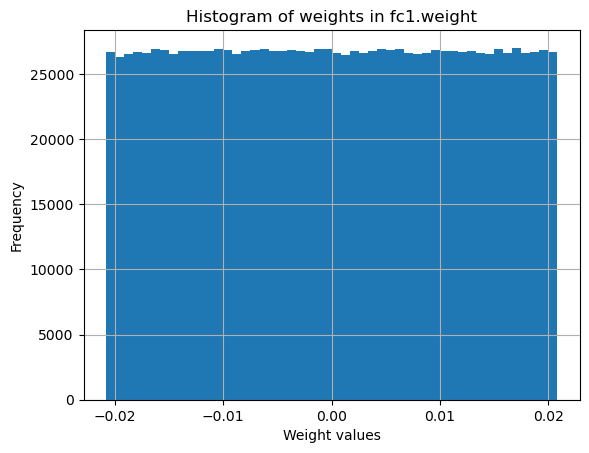

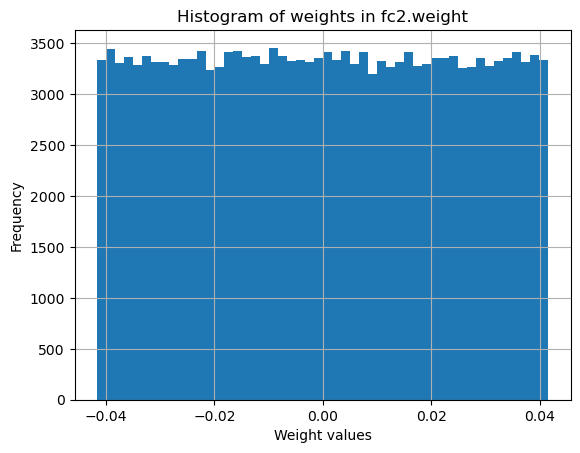

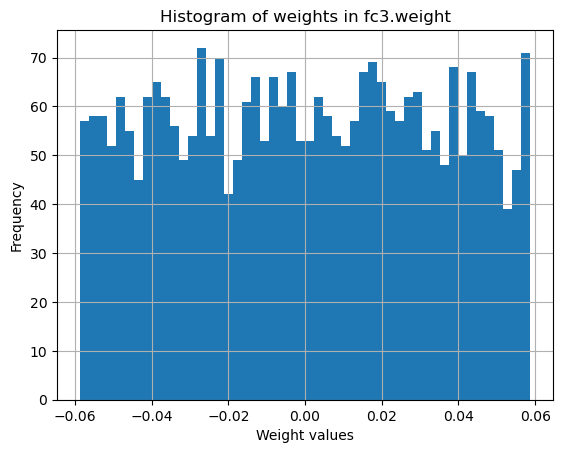

In [50]:
import matplotlib.pyplot as plt

def plot_weight_histograms(model):
    for name, param in model.named_parameters():
        if 'weight' in name:  # Again, focusing on weight tensors
            plt.figure()
            plt.hist(param.data.numpy().flatten(), bins=50)
            plt.title(f"Histogram of weights in {name}")
            plt.xlabel('Weight values')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

# Assuming 'model' is an instance of SNN
plot_weight_histograms(model)


In [20]:
def print_model_parameters_and_buffers(model):
    print("Named Parameters:")
    for name, param in model.named_parameters():
        print(name, type(param))
    print("\nNamed Buffers:")
    for name, buff in model.named_buffers():
        print(name, type(buff))

print_model_parameters_and_buffers(quantized_model)


Named Parameters:

Named Buffers:
lif1.threshold <class 'torch.Tensor'>
lif1.graded_spikes_factor <class 'torch.Tensor'>
lif1.reset_mechanism_val <class 'torch.Tensor'>
lif1.beta <class 'torch.Tensor'>
lif2.threshold <class 'torch.Tensor'>
lif2.graded_spikes_factor <class 'torch.Tensor'>
lif2.reset_mechanism_val <class 'torch.Tensor'>
lif2.beta <class 'torch.Tensor'>
lif3.threshold <class 'torch.Tensor'>
lif3.graded_spikes_factor <class 'torch.Tensor'>
lif3.reset_mechanism_val <class 'torch.Tensor'>
lif3.beta <class 'torch.Tensor'>


In [25]:
def plot_quantized_weight_histograms(model):
    print("Starting to plot...")
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.quantized.Linear):
            # Unpack the weight tensor from the packed parameters
            weight_tensor = module.weight()
            print(f"Plotting for {name}")
            plt.figure()
            plt.hist(weight_tensor.int_repr().numpy().flatten(), bins=50)
            plt.title(f"Histogram of weights in {name}")
            plt.xlabel('Weight values')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
            plt.savefig(f"./notebooks/plots/{name}_weights_histogram.png")  # Save the plot
            print(f"Finished plotting for {name}. Plot saved as {name}_weights_histogram.png")

plot_quantized_weight_histograms(quantized_model)



Starting to plot...
Plotting for fc1
Plotting for fc2
Plotting for fc3


Extra implementations

In [ ]:
import numpy as np

def quantize_weights_to_int8(weights):
    """
    Quantizes the given weights to 8-bit integer values.

    :param weights: The floating-point weights of a neural network layer.
    :return: A tuple of (quantized_weights, scale, zero_point), where
        quantized_weights is an ndarray of int8 values representing the quantized weights,
        scale is the scaling factor used for quantization,
        zero_point is the shift used to align the floating point zero to the center of the int8 range.
    """
    # Calculate the range of the weight values
    min_val, max_val = weights.min(), weights.max()
    
    # Calculate scale and zero_point for the quantization
    scale = (max_val - min_val) / 255
    zero_point = round(128 - max_val / scale)

    # Quantize weights to integer values
    quantized_weights = np.round(weights / scale + zero_point).astype(np.int8)

    # Ensure zero_point is set such that 0.0 maps to an integer value of zero
    quantized_weights = np.clip(quantized_weights, -128, 127)

    return quantized_weights, scale, zero_point

# Dummy weights for demonstration
original_weights = np.random.randn(3, 3).astype(np.float32)

# Perform quantization
quantized_weights, scale, zero_point = quantize_weights_to_int8(original_weights)

# Display results
print("Original weights:")
print(original_weights)
print("\nQuantized weights:")
print(quantized_weights)
print("\nScale:", scale)
print("Zero point:", zero_point)


Original weights:
[[-0.8813357   0.92302275 -1.1838151 ]
 [-1.8286859  -1.3132756  -0.11074793]
 [ 1.3075271  -0.02139866 -1.8684746 ]]

Quantized weights:
[[ -48   97  -72]
 [-124  -82   14]
 [-128   21 -127]]

Scale: 0.012454908034380744
Zero point: 23


Failes attempts

In [ ]:
import torch
from torch import nn
from abc import ABC, abstractmethod

class Quantizer(ABC):
    """
    Base class for quantizers.
    """

    def __repr__(self):
        return f"{self.__class__.__name__}({self._class_repr()})"

    def _class_repr(self):
        """
        Set additional representation for implemented classes
        """
        return ''

    @abstractmethod
    def __call__(self, model: nn.Module):
        """
        Any quantizer should implement the __call__ method

        Args:
            model (nn.Module): Target model for quantization of the weights.
        """
        raise NotImplementedError(f"[{type(self).__name__}] is missing the required '__call__' function")

class RoundAndClamp(Quantizer):
    """
    Performs quantization on the synaptic weights of a model.
    Rounds and clamps the weights to the range [lower_limit, upper_limit],
    remainder is stored as an attribute such that it can be added the next time you call
    the quantizer if add_remainder is True.
    """
    def __init__(self, lower_limit: int, upper_limit: int, add_remainder: bool = False):
        super().__init__()
        self.lower_limit = lower_limit
        self.upper_limit = upper_limit
        self.add_remainder = add_remainder
        self.synaptic_weight_remainder = None

    def _class_repr(self):
        return f"lower_limit={self.lower_limit}, upper_limit={self.upper_limit}, add_remainder={self.add_remainder}"

    def __call__(self, model: nn.Module):
        """
        Rounds and clamps the synaptic weights in each layer of the model.

        Args:
          model (nn.Module): The model to quantize.
        """
        if self.synaptic_weight_remainder is None:
            self.synaptic_weight_remainder = [None] * len(list(model.parameters()))

        for idx, param in enumerate(model.parameters()):
            if param.requires_grad:  # Only quantize trainable parameters
                with torch.no_grad():
                    if self.add_remainder and self.synaptic_weight_remainder[idx] is not None:
                        param.add_(self.synaptic_weight_remainder[idx])
                    param_rounded = torch.round(param)
                    param_clamped = torch.clamp(param_rounded, self.lower_limit, self.upper_limit)
                    if self.add_remainder:
                        self.synaptic_weight_remainder[idx] = param - param_clamped
                    param.copy_(param_clamped)

# Example usage
model = nn.Sequential(nn.Linear(10, 20), nn.ReLU(), nn.Linear(20, 10))
quantizer = RoundAndClamp(-31, 31, add_remainder=True)
quantizer(model)  # Apply quantization


In [1]:
import snntorch
snntorch.__version__

'0.8.0'

In [1]:
import torch
import torch.nn as nn
import snntorch as snn

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=0.7)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.lif2 = snn.Leaky(beta=0.7)

        self.fc3 = nn.Linear(hidden_size, output_size)
        self.lif3 = snn.Leaky(beta=0.7)

    def forward(self, inpt):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spike3_rec = []
        mem3_rec = []

        for step in range(inpt.shape[0]):
            current_input = inpt[step]
            current_input = self.flatten(current_input)

            current1 = self.fc1(current_input)
            spike1, mem1 = self.lif1(current1, mem1)

            current2 = self.fc2(spike1)
            spike2, mem2 = self.lif2(current2, mem2)

            current3 = self.fc3(spike2)
            spike3, mem3 = self.lif3(current3, mem3)

            spike3_rec.append(spike3)
            mem3_rec.append(mem3)

        return torch.stack(spike3_rec, dim=0), torch.stack(mem3_rec, dim=0)


# Dummy data
input_size = 10
hidden_size = 20
output_size = 2
batch_size = 5
time_steps = 50

inputs = torch.randn(time_steps, batch_size, input_size)
targets = torch.randint(0, output_size, (batch_size,))

model = SNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1):
    optimizer.zero_grad()
    spikes, memories = model(inputs)
    # Compute loss on the last time step's output spikes for simplicity
    loss = criterion(spikes[-1], targets)
    loss.backward()
    optimizer.step()

print(f"Training loss: {loss.item()}")

# Save the model
torch.save(model.state_dict(), "snn_model.pth")

# Load the model
loaded_model = SNN(input_size, hidden_size, output_size)

# here is where the error should be produced
loaded_model.load_state_dict(torch.load("snn_model.pth"))

print("Model loaded successfully.")


Training loss: 0.6931471824645996
Model loaded successfully.
